# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?

ANSWER: This is a problem of classification because we need to have a discrete prediction for each student. In other words we will predict whether a student will drop out or graduate from high school. 

## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [ ]:
# Import libraries
import numpy as np
import pandas as pd

In [ ]:
# Read student data
classifiers=['Dec Tree','KNN','SVC','Ran. Forest','Ada Boost']
train_acc=[0 for i in range(5)]
test_acc=[0 for i in range(5)]
student_data = pd.read_csv("student-data.csv")
print("Student data read successfully!")
# Note: The last column 'passed' is the target/label, all other are feature columns
print (student_data)

Student data read successfully!
    school sex  age address famsize  ... Dalc  Walc  health absences passed
0       GP   F   18       U     GT3  ...    1     1       3        6     no
1       GP   F   17       U     GT3  ...    1     1       3        4     no
2       GP   F   15       U     LE3  ...    2     3       3       10    yes
3       GP   F   15       U     GT3  ...    1     1       5        2    yes
4       GP   F   16       U     GT3  ...    1     2       5        4    yes
..     ...  ..  ...     ...     ...  ...  ...   ...     ...      ...    ...
390     MS   M   20       U     LE3  ...    4     5       4       11     no
391     MS   M   17       U     LE3  ...    3     4       2        3    yes
392     MS   M   21       R     GT3  ...    3     3       3        3     no
393     MS   M   18       R     LE3  ...    3     4       5        0    yes
394     MS   M   19       U     LE3  ...    3     3       5        5     no

[395 rows x 31 columns]


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [ ]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
from __future__ import division #This code is necessary otherwise division operator produces zero
student_data_shape = np.shape(student_data)
n_students = student_data_shape[0]
n_features = student_data_shape[1]-1 #-1 is necessary in order to adjust for the presence of target column
n_passed = np.shape(student_data[student_data['passed']=='yes'])[0]
n_failed = np.shape(student_data[student_data['passed']=='no'])[0]
grad_rate = n_passed/n_students*100 
print( "Total number of students: {}".format(n_students))
print( "Number of students who passed: {}".format(n_passed))
print( "Number of students who failed: {}".format(n_failed))
print( "Number of features: {}".format(n_features))
print( "Graduation rate of the class: {:.2f}%".format(grad_rate))

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [ ]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print( "Feature column(s):-\n{}".format(feature_cols))
print( "Target column: {}".format(target_col))

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print( "\nFeature values:-")
print( X_all.head())  # print the first 5 rows

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-
  school sex  age address famsize  ... goout  Dalc  Walc health absences
0     GP   F   18       U     GT3  ...     4     1     1      3        6
1     GP   F   17       U     GT3  ...     3     1     1      3        4
2     GP   F   15       U     LE3  ...     2     2     3      3       10
3     GP   F   15       U     GT3  ...     2     1     1      5        2
4     GP   F   16       U     GT3  ...     2     1     2      5        4

[5 rows x 30 columns]


### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [ ]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print( "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns)))
X_all.iloc[1:5,32]

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


1    0
2    3
3    0
4    0
Name: failures, dtype: int64

### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [ ]:
from sklearn.model_selection import train_test_split
# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train
test_size_value = num_test/num_all
# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=test_size_value, random_state=0)

print( "Training set: {} samples".format(X_train.shape[0]))
print( "Test set: {} samples".format(X_test.shape[0]))
# Note: If you need a validation set, extract it from within training data

Training set: 300 samples
Test set: 95 samples


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

In [ ]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print( "Training {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print( "Done!\nTraining time (secs): {:.15f}".format(end - start))

# TODO: Choose a model, import it and instantiate an object
from sklearn import tree
clf = tree.DecisionTreeClassifier()

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

Training DecisionTreeClassifier...
Done!
Training time (secs): 0.013451337814331


Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.003197431564331
[[ 94   0]
 [  0 206]]
Area under ROC_Curve = 1.000


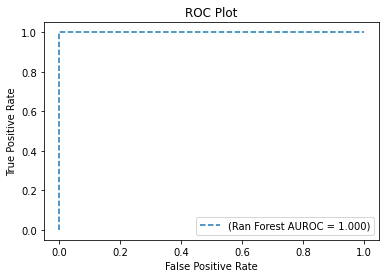

F1 score for traning set: 1.0
accuracy for the training set: 1.0


In [ ]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def predict_labels(clf, features, target):
    print( "Predicting labels using {}...".format(clf.__class__.__name__))
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print ("Done!\nPrediction time (secs): {:.15f}".format(end - start))
    print(confusion_matrix(target, y_pred))
    predictProb=clf.predict_proba(features)
    predictProb=predictProb[:, 1]
    #print(predictProb)
    auc=roc_auc_score(target, predictProb)
    print('Area under ROC_Curve = %.3f' % auc)
    fpr, tpr, _ = roc_curve(target, predictProb,pos_label='yes')
    plt.plot(fpr, tpr, linestyle='--', label='(Ran Forest AUROC = %0.3f)' % auc)
    plt.title('ROC Plot')
    # Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # Show legend
    plt.legend() # 
    # Show plot
    plt.show()
    return (f1_score(target.values, y_pred, pos_label='yes'),accuracy_score(target, y_pred))

train_f1_acc_score = predict_labels(clf, X_train, y_train)
print( "F1 score for traning set: {0[0]}".format(train_f1_acc_score))
print( "accuracy for the training set: {0[1]}".format(train_f1_acc_score))

Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.012653112411499
[[20 16]
 [17 42]]
Area under ROC_Curve = 0.634


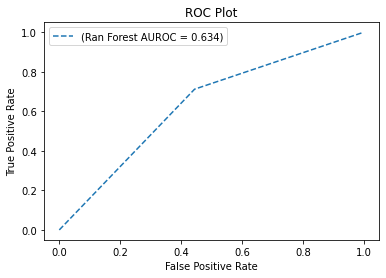

F1 score for test set: 0.717948717948718
accuracy for the test set: 0.6526315789473685


In [ ]:
# Predict on test data
test_f1_acc_score  = predict_labels(clf, X_test,y_test)
print( "F1 score for test set: {0[0]}".format(test_f1_acc_score))
print( "accuracy for the test set: {0[1]}".format(test_f1_acc_score))

------------------------------------------
Training set size: 100
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.007425785064697
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.004102230072021
[[36  0]
 [ 0 64]]
Area under ROC_Curve = 1.000


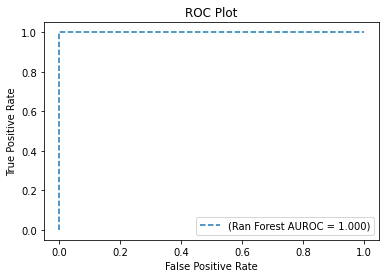

(F1 score,Accuracy) for training set: (1.0, 1.0) , 
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.003960371017456
[[21 15]
 [18 41]]
Area under ROC_Curve = 0.639


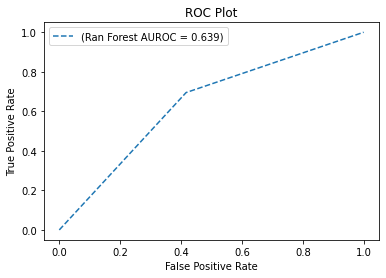

(F1 score,Accuracy) for test set: (0.7130434782608696, 0.6526315789473685)
------------------------------------------
Training set size: 200
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.006695508956909
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.003181219100952
[[ 67   0]
 [  0 133]]
Area under ROC_Curve = 1.000


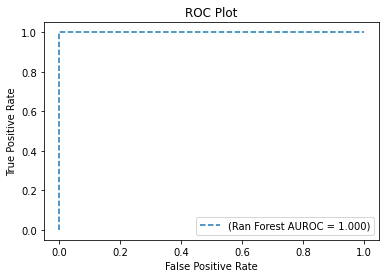

(F1 score,Accuracy) for training set: (1.0, 1.0) , 
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.002175092697144
[[12 24]
 [14 45]]
Area under ROC_Curve = 0.548


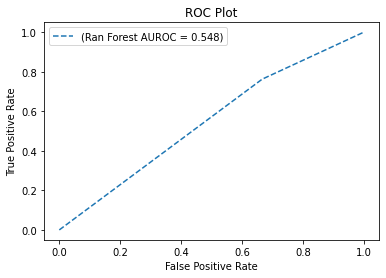

(F1 score,Accuracy) for test set: (0.703125, 0.6)
------------------------------------------
Training set size: 300
Training DecisionTreeClassifier...
Done!
Training time (secs): 0.006579637527466
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.004794597625732
[[ 94   0]
 [  0 206]]
Area under ROC_Curve = 1.000


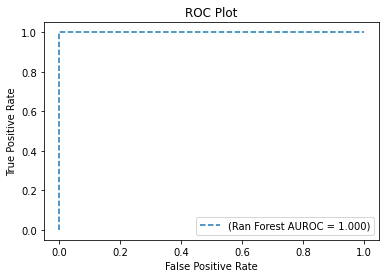

(F1 score,Accuracy) for training set: (1.0, 1.0) , 
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.003449678421021
[[19 17]
 [17 42]]
Area under ROC_Curve = 0.620


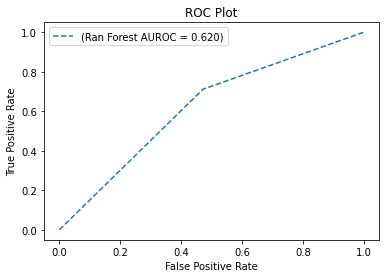

(F1 score,Accuracy) for test set: (0.711864406779661, 0.6421052631578947)


In [ ]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print( "------------------------------------------")
    print( "Training set size: {}".format(len(X_train)))
    train_classifier(clf, X_train, y_train)
    print( "(F1 score,Accuracy) for training set: {} , ".format(predict_labels(clf, X_train, y_train)))
    print( "(F1 score,Accuracy) for test set: {}".format(predict_labels(clf, X_test, y_test)))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
train_predict(clf, X_train[:100], y_train[:100], X_test, y_test)
train_predict(clf, X_train[:200], y_train[:200], X_test, y_test)
train_predict(clf, X_train[:300], y_train[:300], X_test, y_test)


------------------------------------------
Training set size: 100
Training SVC...
Done!
Training time (secs): 0.009913682937622
Predicting labels using SVC...
Done!
Prediction time (secs): 0.005608320236206
[[ 2 34]
 [ 0 64]]
Area under ROC_Curve = 0.823


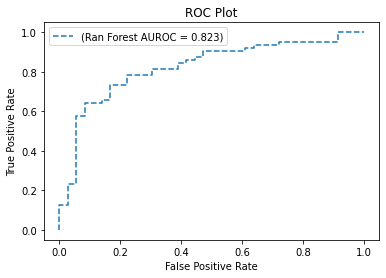

(F1 score,Accuracy) for training set: (0.7901234567901235, 0.66) , 
Predicting labels using SVC...
Done!
Prediction time (secs): 0.004228591918945
[[ 0 36]
 [ 1 58]]
Area under ROC_Curve = 0.684


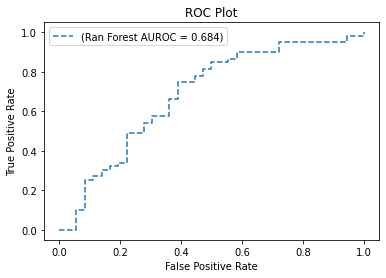

(F1 score,Accuracy) for test set: (0.7581699346405228, 0.6105263157894737)
------------------------------------------
Training set size: 200
Training SVC...
Done!
Training time (secs): 0.015020132064819
Predicting labels using SVC...
Done!
Prediction time (secs): 0.005166530609131
[[  0  67]
 [  0 133]]
Area under ROC_Curve = 0.796


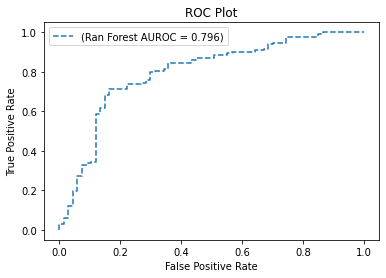

(F1 score,Accuracy) for training set: (0.7987987987987988, 0.665) , 
Predicting labels using SVC...
Done!
Prediction time (secs): 0.005445480346680
[[ 0 36]
 [ 0 59]]
Area under ROC_Curve = 0.769


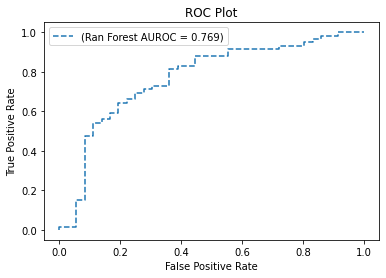

(F1 score,Accuracy) for test set: (0.7662337662337663, 0.6210526315789474)
------------------------------------------
Training set size: 300
Training SVC...
Done!
Training time (secs): 0.027417421340942
Predicting labels using SVC...
Done!
Prediction time (secs): 0.007454872131348
[[  3  91]
 [  1 205]]
Area under ROC_Curve = 0.786


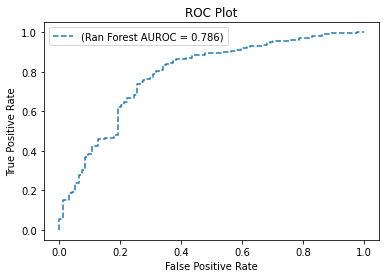

(F1 score,Accuracy) for training set: (0.8167330677290836, 0.6933333333333334) , 
Predicting labels using SVC...
Done!
Prediction time (secs): 0.004722118377686
[[ 1 35]
 [ 1 58]]
Area under ROC_Curve = 0.749


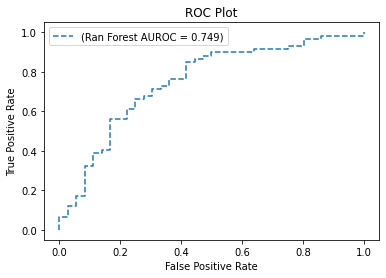

(F1 score,Accuracy) for test set: (0.7631578947368421, 0.6210526315789474)


In [ ]:
# TODO: Train and predict using two other models
from sklearn import svm
clf = svm.SVC(probability = True)
train_predict(clf, X_train[:100], y_train[:100], X_test, y_test)
train_predict(clf, X_train[:200], y_train[:200], X_test, y_test)
train_predict(clf, X_train[:300], y_train[:300], X_test, y_test)

------------------------------------------
Training set size: 100
Training KNeighborsClassifier...
Done!
Training time (secs): 0.003746747970581
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.014430761337280
[[13 23]
 [ 8 56]]
Area under ROC_Curve = 0.764


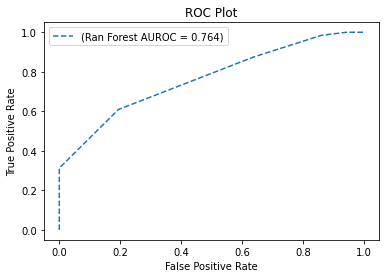

(F1 score,Accuracy) for training set: (0.7832167832167832, 0.69) , 
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.007740497589111
[[10 26]
 [12 47]]
Area under ROC_Curve = 0.598


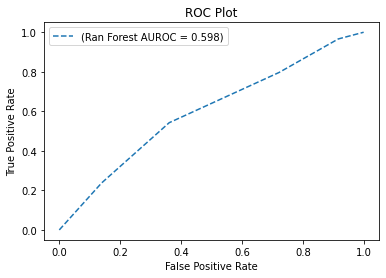

(F1 score,Accuracy) for test set: (0.712121212121212, 0.6)
------------------------------------------
Training set size: 200
Training KNeighborsClassifier...
Done!
Training time (secs): 0.003208637237549
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.012310028076172
[[ 36  31]
 [  9 124]]
Area under ROC_Curve = 0.837


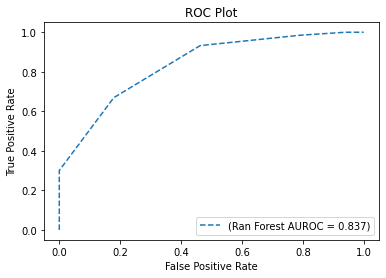

(F1 score,Accuracy) for training set: (0.8611111111111112, 0.8) , 
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.007594108581543
[[ 9 27]
 [12 47]]
Area under ROC_Curve = 0.580


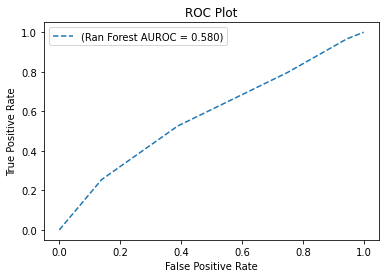

(F1 score,Accuracy) for test set: (0.7067669172932329, 0.5894736842105263)
------------------------------------------
Training set size: 300
Training KNeighborsClassifier...
Done!
Training time (secs): 0.004393577575684
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.019112825393677
[[ 45  49]
 [  8 198]]
Area under ROC_Curve = 0.857


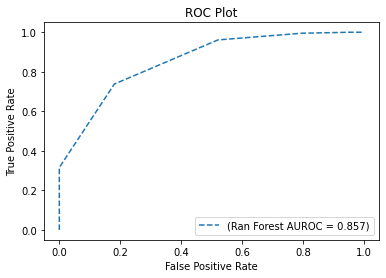

(F1 score,Accuracy) for training set: (0.8741721854304636, 0.81) , 
Predicting labels using KNeighborsClassifier...
Done!
Prediction time (secs): 0.010920524597168
[[ 8 28]
 [ 7 52]]
Area under ROC_Curve = 0.608


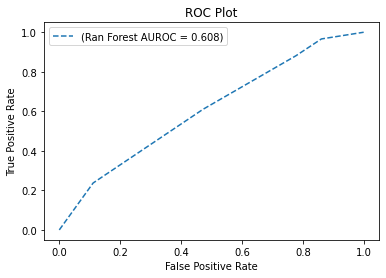

(F1 score,Accuracy) for test set: (0.7482014388489208, 0.631578947368421)


In [ ]:
# TODO: Train and predict using two other models
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier()
train_predict(clf, X_train[:100], y_train[:100], X_test, y_test)
train_predict(clf, X_train[:200], y_train[:200], X_test, y_test)
train_predict(clf, X_train[:300], y_train[:300], X_test, y_test)

In [ ]:
data = {'labels': ['Size_100', 'Size_200', 'Size_300'],
            'Train_times': [0.01,0,0.01],
            'Predtime_train': [0,0.02,0.03],
            'Predtime_test': [0,0.01,0.01],
            'F1_train': [0.80,0.860,0.87],
            'F1_test': [0.71,0.71,0.75]}
KNN_data = pd.DataFrame(data)
print( 'Performance for KNN:')
print( KNN_data)
data = {'labels': ['Size_100', 'Size_200', 'Size_300'],
            'Train_times': [0,0.01,0.01],
            'Predtime_train': [0.01,0,0],
            'Predtime_test': [0,0,0],
            'F1_train': [1,1,1],
            'F1_test': [0.69,0.74,0.70]}
Decision_data = pd.DataFrame(data)
print( 'Performance for Decision Tree:')
print( Decision_data)
data = {'labels': ['Size_100', 'Size_200', 'Size_300'],
            'Train_times': [0.01,0.01,0.02],
            'Predtime_train': [0,0.01,0.02],
            'Predtime_test': [0,0.01,0.01],
            'F1_train': [0.859,0.869,0.869],
            'F1_test': [0.784,0.775,0.758]}
SVM_data = pd.DataFrame(data)
print( 'Performance for SVM:')
print( SVM_data)

Performance for KNN:
     labels  Train_times  Predtime_train  Predtime_test  F1_train  F1_test
0  Size_100         0.01            0.00           0.00      0.80     0.71
1  Size_200         0.00            0.02           0.01      0.86     0.71
2  Size_300         0.01            0.03           0.01      0.87     0.75
Performance for Decision Tree:
     labels  Train_times  Predtime_train  Predtime_test  F1_train  F1_test
0  Size_100         0.00            0.01              0         1     0.69
1  Size_200         0.01            0.00              0         1     0.74
2  Size_300         0.01            0.00              0         1     0.70
Performance for SVM:
     labels  Train_times  Predtime_train  Predtime_test  F1_train  F1_test
0  Size_100         0.01            0.00           0.00     0.859    0.784
1  Size_200         0.01            0.01           0.01     0.869    0.775
2  Size_300         0.02            0.02           0.01     0.869    0.758


## General Discussion for each Model:
### Decision Tree Algorithm: 
Decision trees create a model or a tree that predicts the value of a target variable(in this cassed passed) by learning simple decision rules from the data. For example in our data set it is most likely that children with only one guardian are more likely to drop out of school. In this case a simple decision tree with one node would classify pupils as dropouts if one of the guardian variables are zero.
#### Advantages and Disadvantages of Decision Trees:
Decision trees have many advantages. First of all they can be easiliy visualized. This is not possible in case of many other algorithms. For example, in SVM, it is basically impossible for us to imagine data in 10 dimensional space. Secondly, they have logarithmic run times, therefore they are very fast. When examining the performance table above you can see that they are the fastest. Another advantage would be that decision trees can use categorical data even without any formating, however in our examples we are already preprocessing data, so we are taking advantage of this feature.

Several disadvantages exist. First it is easy to see from the performance table that the decision tree that we have created is overfitting and there is huge difference between F1 scores of training and testing data sets. Second disadvantage is that decision trees do not perform well if one the classes dominates, but I think in this case it is 30% vs. 70%, so they are roughly equal.

Given this discussion, I tried decision trees for this particular problem because they are usually used for classification, easy to understand and visualize and suitable for our data where most of the features are categorical.
### Support Vector Machines: 
Support vector machines are a set of classifiers that try to find the optimum linear seperator between two classes. Although in reality most data would not be linearly seperable, SVM uses a kernel trick that adds news features into the data by combining existing features in various ways. For example a set of data points containing x and y features may not be linearly seperable in two dimensional space, but they may be in three dimensional space where x^2+y^2 is the third variable.
#### Advantages and Disadvantages of Support Vector Machines:
There are two advantages of using support vector machines. One is that they use only a small subset of data in order to train model and they are called support vectors. This is a more memory efficient method in situations where we have tons of data. A second advantage is that they are robust in cases where the number of data points are on the order of the number of features. In other words they suffer less from the curse of dimensionality.

There may be two disadvanges. One is that it may difficult to explain how they work. The concept of high dimensionalty may be difficult to grasp. SVM also does not work when the number of features are much bigger than data, but this is rarely the case.
I think it is suitable in this case because it is a widely used classification algorithm that performs best right out of the box.
### K nearest neighbours algorithm: 
Classifiction based on nearest neighbours algorithm is one where no explicit model for the data is constructed. Classifier simply stores the data and whenever a new point comes, classifier assings the new point to a class based on its closest k neighbours.
#### Advantages and Disadvantages of KNN:
The main advantage of KNN is that training times are short. There is essentially no training and no model. Therefore it is easy to update KNN as the new data comes.  Another advantage is that it will be very easy to explaing this model in laymen's terms. However the disadvantage is that predicting each new data point takes a long time. For each data point we have to calculate its nearest neighbours. Another disadvantage is the curse of dimensionality as explaing by Charles Isbell during the lectures. As the dimensions of the feature space increases each data point is going to represent a bigger volume of space for which it may not be representative. 
I wanted to try KNN also as it is a very simple algorithms that makes no assumption about the data.


## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

#### Justification for the final model:

Based on all the experiments I have done, I have settled on a decision tree. First reason is the computational costs. Among three algorithms, decision tree had the lowest prediction and training times. In terms of performance, although decision tree came last, this was because decision tree algorithm overfits right out of the box. We can see this if we compare F1 scores on the training and testing set. F1 score on the trainig set is 1, but F1 score on the testing set is low. This is not the case for other algorithms. Therefore I don't think this is a reason to reject decision tree and it can be optimized.

Final F1 score for my optimized model was 79.2%.

#### How are decision trees constructed and how do they make predictions?

Decision trees are diagrams that look like trees. They have nodes, leafs and edges. In order to construct a decision tree, the computer looks at each of the features and tries to find a feature that correlates best with the target variables. Seperating our data in two groups based on this feature would provide the biggest increase in uniformity or information gain. Then we place one of the groups in one node and the second half in the second node. We continue this process until we get the most uniform leafs possible, i.e. only containing one of classes. In a way this is like playing the game of 20 questions. When we start the game we ask whether the object is a plant, animal or a human. Depending on the answer we get, we ask more and more specific questions that narrows down our choices. Decision trees do this in a process called minimizing the entrophy or disorder in the data. In other words, which question should I ask that would put all the objects of one class to the one side, and all the other objects of the second class to the other side.Once we find these set of question we can construct our decision tree.

I have included a picture of my decision tree below. Here's how they make a prediction. We start by asking a question at the top. In this case whether variable X[32] which is labelled failures is less than 0.5. If it is less than 0.5, mostly graduates go to the left and if it is more than 0.5 mostly dropouts go the right. We continue this process until we reach one of the leafs, which tell us that a decision is reached. For example if you end up in the very first leaf, you can see that it contains mostly graduates (172 graduate and only 42 dropouts), therefore the anwer is going to be "yes", this student is going to graduate. However if you look at the third leaf, you can see that it contains most dropouts (16 dropouts and 3 graduates), so we can identify a student as a future dropout if it ends up in this leaf.


In [ ]:
from IPython.display import Image
Image("tree.png")

{'max_depth': 4, 'min_samples_split': 6}
0.7794117647058822
0.6842105263157895
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.001837253570557
[[ 44  50]
 [ 11 195]]
Area under ROC_Curve = 0.774


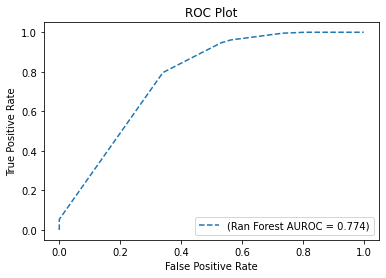

Train: (0.8647450110864745, 0.7966666666666666)
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.002925872802734
[[12 24]
 [ 6 53]]
Area under ROC_Curve = 0.619


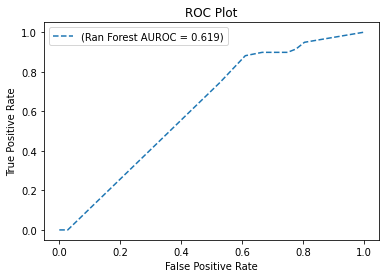

Test: (0.7794117647058822, 0.6842105263157895)
[0.7966666666666666, 0, 0, 0, 0]
[0.6842105263157895, 0, 0, 0, 0]
['Dec Tree', 'KNN', 'SVC', 'Ran. Forest', 'Ada Boost']


In [ ]:
# TODO: Fine-tune your model and report the best F1 score
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import make_scorer,f1_score,accuracy_score

#Find the best parameters
scoring_function = make_scorer(accuracy_score)
parameters = {'max_depth':[3, 4, 5, 6, 7],'min_samples_split':[6, 8, 10, 12, 14, 16]}
tree_clf = tree.DecisionTreeClassifier()
optimum_tree = model_selection.GridSearchCV(tree_clf, parameters,scoring=scoring_function)
optimum_tree.fit(X_train, y_train) 
print( optimum_tree.best_params_)

#Print the F1 score for the optimum tree
y_pred = optimum_tree.predict(X_test)
print( f1_score(y_test.values, y_pred,pos_label='yes'))
print(accuracy_score(y_test.values, y_pred))
# clf = tree.DecisionTreeClassifier(max_depth=3,min_samples_split=12)
# clf.fit(X_train,y_train)
f_score,acc_score=predict_labels(optimum_tree, X_train, y_train)
train_acc[0]=acc_score
print('Train:',(f_score,acc_score))
f_score,acc_score=predict_labels(optimum_tree, X_test, y_test)
test_acc[0]=acc_score
print('Test:',(f_score,acc_score))

print(train_acc)
print(test_acc)
print(classifiers)

{'n_neighbors': 9}
0.8028169014084507
0.7052631578947368
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.019142627716064
[[ 30  64]
 [  9 197]]
Area under ROC_Curve = 0.759


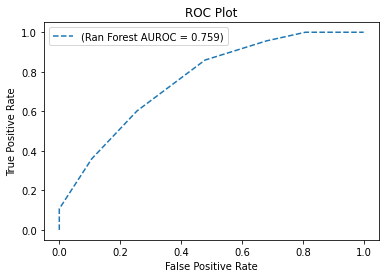

Train: (0.8436830835117773, 0.7566666666666667)
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.016066312789917
[[10 26]
 [ 2 57]]
Area under ROC_Curve = 0.650


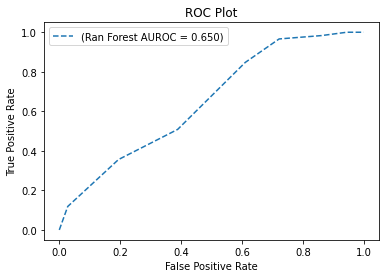

Test: (0.8028169014084507, 0.7052631578947368)
[0.7966666666666666, 0.7566666666666667, 0, 0, 0]
[0.6842105263157895, 0.7052631578947368, 0, 0, 0]
['Dec Tree', 'KNN', 'SVC', 'Ran. Forest', 'Ada Boost']


In [ ]:
#Some optimization for KNN
# TODO: Fine-tune your model and report the best F1 score
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import make_scorer,f1_score,accuracy_score

#Find the best parameters
scoring_function = make_scorer(accuracy_score)
parameters = {'n_neighbors':[3, 4, 5, 6, 7, 8, 9, 10]}
knn_clf = neighbors.KNeighborsClassifier()
optimum_tree = model_selection.GridSearchCV(knn_clf, parameters,scoring=scoring_function)
optimum_tree.fit(X_train, y_train) 
print( optimum_tree.best_params_)

#Print the F1 score for the optimum tree
y_pred = optimum_tree.predict(X_test)
print( f1_score(y_test.values, y_pred,pos_label='yes'))
print(accuracy_score(y_test.values, y_pred))
f_score,acc_score=predict_labels(optimum_tree, X_train, y_train)
train_acc[1]=acc_score
print('Train:',(f_score,acc_score))
f_score,acc_score=predict_labels(optimum_tree, X_test, y_test)
test_acc[1]=acc_score
print('Test:',(f_score,acc_score))
print(train_acc)
print(test_acc)
print(classifiers)

{'C': 0.4, 'gamma': 0.01, 'kernel': 'poly'}
0.7659574468085107
0.6526315789473685
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.005529165267944
[[ 49  45]
 [  4 202]]
Area under ROC_Curve = 0.872


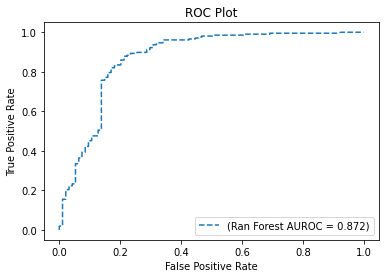

Train: (0.891832229580574, 0.8366666666666667)
Predicting labels using GridSearchCV...
Done!
Prediction time (secs): 0.002766609191895
[[ 8 28]
 [ 5 54]]
Area under ROC_Curve = 0.759


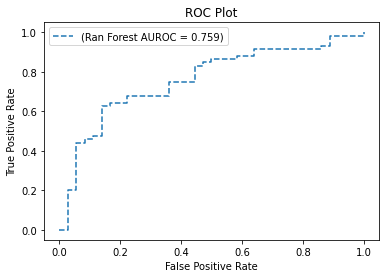

Test: (0.7659574468085107, 0.6526315789473685)
[0.7966666666666666, 0.7566666666666667, 0.8366666666666667, 0, 0]
[0.6842105263157895, 0.7052631578947368, 0.6526315789473685, 0, 0]
['Dec Tree', 'KNN', 'SVC', 'Ran. Forest', 'Ada Boost']


In [ ]:
#Some optimization for SVM
# TODO: Fine-tune your model and report the best F1 score
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import make_scorer,f1_score,accuracy_score

#Find the best parameters
scoring_function = make_scorer(accuracy_score)
parameters = {'kernel':['linear', 'poly', 'rbf', 'sigmoid', ], 'C':[0.4,0.6,0.8,1], 'gamma':[0.01,0.1,0.2,0.5,1]}
new_clf = svm.SVC(probability=True)
optimum_tree = model_selection.GridSearchCV(new_clf, parameters,scoring=scoring_function)
optimum_tree.fit(X_train, y_train) 
print( optimum_tree.best_params_)

#Print the F1 score for the optimum tree
y_pred = optimum_tree.predict(X_test)
print( f1_score(y_test.values, y_pred,pos_label='yes'))
print(accuracy_score(y_test.values, y_pred))
f_score,acc_score=predict_labels(optimum_tree, X_train, y_train)
train_acc[2]=acc_score
print('Train:',(f_score,acc_score))
f_score,acc_score=predict_labels(optimum_tree, X_test, y_test)
test_acc[2]=acc_score
print('Test:',(f_score,acc_score))
print(train_acc)
print(test_acc)
print(classifiers)

### **Random Forest Classifier**

In [ ]:
# find a good # of estimators
from sklearn.ensemble import RandomForestClassifier

ne=[]
for i in range(1,58):
    forest = RandomForestClassifier(n_estimators=i)
    f = forest.fit(X_train, y_train)
    fs = f.score(X_test, y_test)
    ne.append(fs)
ne = pd.Series(ne)
ne.where(ne==ne.max()).dropna()

26    0.726316
dtype: float64

In [ ]:
# find a good # of min_samples_leaf
from sklearn.ensemble import RandomForestClassifier

ne=[]
for i in range(1,58):
    forest = RandomForestClassifier(n_estimators=21, min_samples_leaf=i)
    f = forest.fit(X_train, y_train)
    fs = f.score(X_test, y_test)
    ne.append(fs)
ne = pd.Series(ne)
ne.where(ne==ne.max()).dropna()

1    0.705263
dtype: float64

Random Forest Model Score : 0.8433333333333334 , Cross Validation Score : 0.6736842105263158
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.007481813430786
[[ 49  45]
 [  2 204]]
Area under ROC_Curve = 0.973


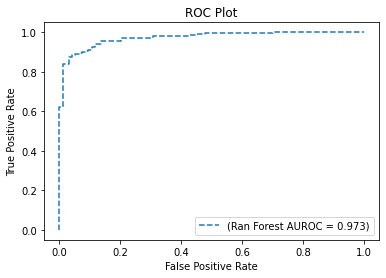

Train: (0.8967032967032967, 0.8433333333333334)
Predicting labels using RandomForestClassifier...
Done!
Prediction time (secs): 0.010503768920898
[[ 6 30]
 [ 1 58]]
Area under ROC_Curve = 0.763


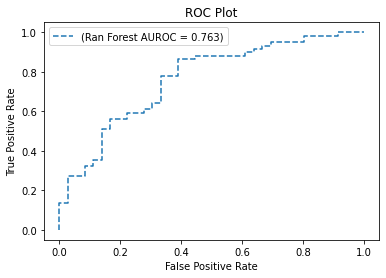

Test: (0.7891156462585034, 0.6736842105263158)
[0.7966666666666666, 0.7566666666666667, 0.8366666666666667, 0.8433333333333334, 0]
[0.6842105263157895, 0.7052631578947368, 0.6526315789473685, 0.6736842105263158, 0]
['Dec Tree', 'KNN', 'SVC', 'Ran. Forest', 'Ada Boost']


In [ ]:
# final model
forest = RandomForestClassifier(n_estimators=36, min_samples_leaf=4)
f = forest.fit(X_train, y_train)
print("Random Forest Model Score" , ":" , f.score(X_train, y_train) , "," ,"Cross Validation Score" ,":" , f.score(X_test, y_test))
f_score,acc_score=predict_labels(f, X_train, y_train)
train_acc[3]=acc_score
print('Train:',(f_score,acc_score))
f_score,acc_score=predict_labels(f, X_test, y_test)
test_acc[3]=acc_score
print('Test:',(f_score,acc_score))
print(train_acc)
print(test_acc)
print(classifiers)

# **Ada Boost Classfier**

Ada Boost Model Score : 0.7733333333333333 , Cross Validation Score : 0.6842105263157895
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.005902290344238
[[ 39  55]
 [ 13 193]]
Area under ROC_Curve = 0.816


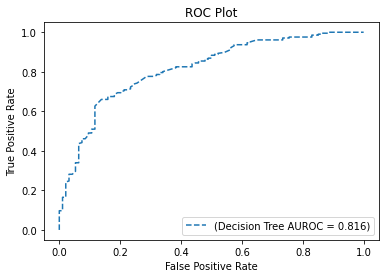

Train: (0.8502202643171807, 0.7733333333333333)
Predicting labels using AdaBoostClassifier...
Done!
Prediction time (secs): 0.005812406539917
[[11 25]
 [ 5 54]]
Area under ROC_Curve = 0.706


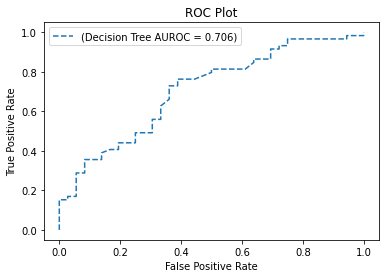

Test: (0.782608695652174, 0.6842105263157895)
[0.7766666666666666, 0.7566666666666667, 0.8366666666666667, 0.86, 0.7733333333333333]
[0.6842105263157895, 0.7052631578947368, 0.6526315789473685, 0.6631578947368421, 0.6842105263157895]
['Dec Tree', 'KNN', 'SVC', 'Ran. Forest', 'Ada Boost']


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=15)
af = ada.fit(X_train, y_train)
print("Ada Boost Model Score" , ":" , af.score(X_train, y_train) , "," ,
      "Cross Validation Score" ,":" , af.score(X_test, y_test))
f_score,acc_score=predict_labels(af, X_train, y_train)
train_acc[4]=acc_score
print('Train:',(f_score,acc_score))
f_score,acc_score=predict_labels(af, X_test, y_test)
test_acc[4]=acc_score
print('Test:',(f_score,acc_score))
print(train_acc)
print(test_acc)
print(classifiers)

[0.7766666666666666, 0.7566666666666667, 0.8366666666666667, 0.85, 0]
[0.6842105263157895, 0.7052631578947368, 0.6526315789473685, 0.6842105263157895, 0]
['Dec Tree', 'KNN', 'SVC', 'Ran. Forest', 'Ada Boost']


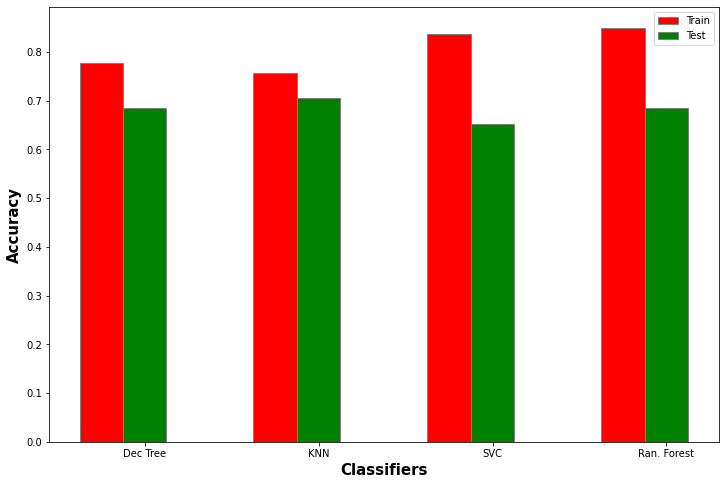

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
 
def compare_metrics(train,test,classifiers):
    # set width of bar
  train=train[:-1]
  test=test[:-1]
  barWidth = 0.25
  fig = plt.subplots(figsize =(12, 8))
  
  # set height of bar
  # Set position of bar on X axis
  br1 = np.arange(len(train))
  br2 = [x + barWidth for x in br1]
  
  # Make the plot
  plt.bar(br1, train, color ='r', width = barWidth,
          edgecolor ='grey', label ='Train')
  plt.bar(br2, test, color ='g', width = barWidth,
          edgecolor ='grey', label ='Test')
  
  # Adding Xticks
  plt.xlabel('Classifiers', fontweight ='bold', fontsize = 15)
  plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
  plt.xticks([r + barWidth for r in range(len(train))],
          classifiers)
  
  plt.legend()
  plt.show()
# set width of bar
print(train_acc)
print(test_acc)
print(classifiers)
compare_metrics(train_acc,test_acc,classifiers)